In [45]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from sklearn.decomposition import PCA

import autograd.numpy as anp
from autograd import grad

import pickle as pck
import math

In [46]:
# potential
def Vpot(r):
    x, y = r
    return (x**4 + y**4) / 20480 \
      - 3 *  anp.exp(-0.01 * ((x+5)**2) - 0.2 * ((y+5) ** 2)) \
      - 3 * anp.exp(-0.01 * ((x - 5) ** 2) - 0.2 * ((y - 5) ** 2)) \
      + 5 * anp.exp(-0.2 * ((x + 3 * (y - 3)) ** 2)) / (1 + anp.exp(-1 * x - 3)) \
      + 5 * anp.exp(-0.2 * ((x + 3*(y + 3))) ** 2) / (1 + anp.exp(x - 3)) \
      + 3 * anp.exp(-0.01 * (x ** 2 + y ** 2))

def Vxy(x, y):
    return Vpot([x, y])

partial_derivative_x = grad(Vxy, 0)
partial_derivative_y = grad(Vxy, 1)

def dVdx(r):
    x, y = map(float, r)
    return partial_derivative_x(x, y)


# dV/dy
def dVdy(r):
    x, y = map(float, r)
    return partial_derivative_y(x, y) 
# compute kinetic energy

def Ekin(v, m=1.0):
    vx, vy = v
    v_mag_squared = vx ** 2 + vy ** 2
    return .5 * m * (v_mag_squared)

# check if particle is in A or B
def in_A(r):
    x, y = r
    return x < -4.0 and y < -3.0
    
def in_B(r):
    x, y = r
    return x > 4.0 and y > 3.0

In [47]:
r = [2.0, 3.0]
print("dV/dx:", dVdx(r))
print("dV/dy:", dVdy(r))



dV/dx: -1.9480771441418816
dV/dy: -6.494201378111789


In [48]:
from numpy.random import default_rng
import numpy as np

# MD step
rng = default_rng(23)


def mdstep(r, v, f, dt, lc):
    """MD step using Langevin dynamics

    Parameters
    ----------
    r:
        positions
    v:
        velocities
    f:
        forces
    dt:
        time step
    lc:
        coefficients for Langevin dynamics

    Return
    ---------
    r:
        updated positions
    v:
        updated velocities
    f:
        updated forces

    """

    # mass is set to 1.0 here, does not explicitly appear in the equations

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    # Verlet part of MD step
    v = v + 0.5 * f * dt
    r = r + dt * v

    # compute forces for new position, dVdx and dVdy are the partial derivatives wrt x and y
    f = np.array([-dVdx(r), -dVdy(r)])

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    return r, v, f

In [ ]:
# set time step and temperature
dt = 0.05
beta = 1.5

# initialize random number generator
rng = default_rng(27)

# initialize langevin parameters
lgamma = 1.0
c1 = np.exp(-lgamma*dt/2.0)
c2 = np.sqrt((1.0-(c1*c1))/beta)
lc = np.array([c1,c2])

# initialize position, velocities, and forces
r = np.array([0.0,0.0])
v =np.array([np.sqrt(1.0/beta)*rng.standard_normal(),np.sqrt(1.0/beta)*rng.standard_normal()])
f = np.array([-dVdx(r), -dVdy(r)])

# rescale initial velocities to target temperature 
# you need to add the function to compute Ekin
scale = np.sqrt(1.0/beta/Ekin(v))
v = v*scale
print(f'Initial beta = {1.0/Ekin(v):.3f}')

sum_Ekin = 0.0
count = 0
positions = []
for i in range(1000):
    for k in range(100):
        r,v,f = mdstep(r,v,f,dt,lc)
        count = count + 1
        sum_Ekin = sum_Ekin + Ekin(v)
    # add function in_A(r) and in_B(r) to determine if system is in A or B
    positions.append(r)
    print(i)
    # print(f'x = {r[0]:.3f}, y = {r[1]:.3f}, average beta = {1.0/(sum_Ekin/count):.3f}, A = {in_A(r)}, B = {in_B(r)}')
    


Initial beta = 1.500


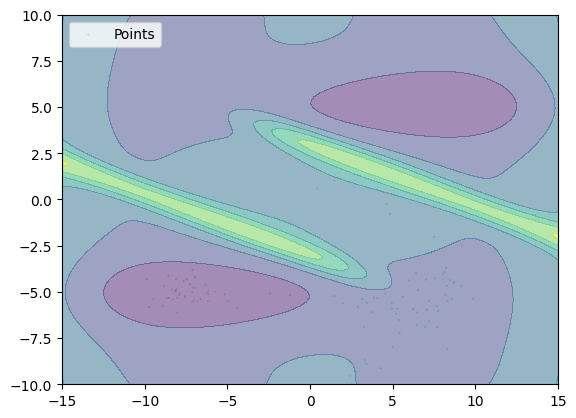

In [ ]:
nx = 100
ny = 100
x = np.linspace(-15, 15, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
fig = plt.figure() 
plt.contourf(x,y,z_grid, alpha=.5)

positions = np.array(positions)

# Extract x and y coordinates
x_positions = positions[:, 0]
y_positions = positions[:, 1]

def decide_color(r):
  if in_A(r):
    return "purple"
  return "green"

colors = [decide_color(pos) for pos in positions]

plt.scatter(x_positions, y_positions, color=colors, label='Points', zorder=3, s=.01)
plt.legend(loc='upper left')
plt.show()

In [ ]:
def pca(X, num_components):
    """ Performs PCA for a given number of components. Returns reduced data and eigenvectors (principal components).

    Parameters:
    -----------
    X : Array to perform PCA on.
    num_components : Number of principal components of interest.
    """
    # subtract mean
    x = X - np.mean(X, axis=0)

    # covariance matrix
    cov_mat = np.cov(x, rowvar=False)

    # Diagonalize covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_mat)

    # Sort
    sorted_ids = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_ids]
    eigvals_sorted = eigvals[sorted_ids]

    # Select requested eigenvectors
    eigvecs_selected = eigvecs_sorted[:, 0:num_components]
    eigvals_selected = eigvals_sorted[0:num_components]


    # Project data onto eigenvectors
    X_projected = np.dot(eigvecs_selected.transpose(), x.transpose()).transpose()

    return X_projected, eigvecs_selected, eigvals_selected

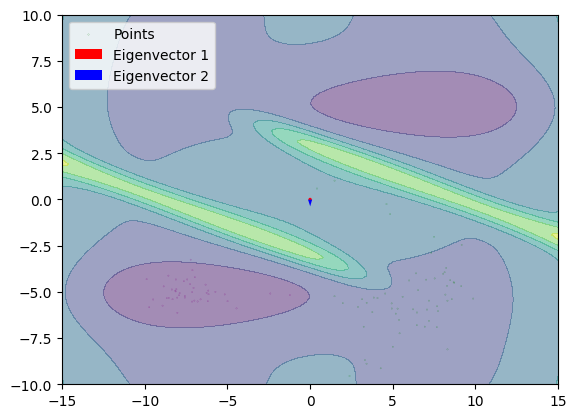

In [ ]:
nx = 100
ny = 100
x = np.linspace(-15, 15, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
fig = plt.figure() 
plt.contourf(x,y,z_grid, alpha=.5)

positions = np.array(positions)

# Extract x and y coordinates
x_positions = positions[:, 0]
y_positions = positions[:, 1]

def decide_color(r):
  if in_A(r):
    return "purple"
  return "green"

colors = [decide_color(pos) for pos in positions]

plt.scatter(x_positions, y_positions, color=colors, label='Points', zorder=3, s=.01)

# plt.show()


_, eigenvectors, eigenvalues = pca(positions, 2)
for i in range(len(eigenvalues)):
  eigenvector = eigenvectors[i]
  plt.quiver(
          0, 0,  # Start point
          eigenvector[0], eigenvector[1],  # Direction
          scale=eigenvalues[i], scale_units='xy', angles='xy', color=['r', 'b'][i],
          label=f"Eigenvector {i+1}"
      )
plt.legend(loc='upper left')
plt.show()
